<a href="https://colab.research.google.com/github/DarShabi/OCR-Company-Project/blob/main/Week%234/Visualization_NAimg.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install -q ImageHash

In [ ]:
from PIL import Image
from PIL import ImageEnhance, ImageOps
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import os
import requests
import glob
import json
from collections import Counter, defaultdict
import re
import matplotlib.image as mpimg
import seaborn as sns
import cv2
import imagehash
from sklearn.model_selection import train_test_split
import cv2
import re
import urllib.request
import time

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Loading Data

In [ ]:
data_path = '/content/drive/MyDrive/OCR_Project/data.csv'

df = pd.read_csv(data_path)

In [ ]:
NA_df = pd.read_csv('/content/drive/MyDrive/OCR_Project/N_A_images.csv')

# Splitting, converting NaN to 'unknown'

In [ ]:
nan_count_before = df['text'].isnull().sum()
print(f"Number of NaN values before replacement: {nan_count_before}")

Number of NaN values before replacement: 1031


In [ ]:
# Replace 'NaN' with 'unknown'
df['text'].fillna('unknown', inplace=True)

In [ ]:
# Check the count of 'NaN' after replacement
nan_count_after = df['text'].isnull().sum()
print(f"Number of NaN values after replacement: {nan_count_after}")

Number of NaN values after replacement: 0


In [ ]:
# Initial split: 80% train, 20% temp
train_df, temp_df = train_test_split(df, test_size=0.3, random_state=42)

# Split the 20% temp into half: 10% validation, 10% test
val_df, test_df = train_test_split(temp_df, test_size=2/3, random_state=42)

print(f"Train size: {len(train_df)}")
print(f"Validation size: {len(val_df)}")
print(f"Test size: {len(test_df)}")

Train size: 3407
Validation size: 487
Test size: 974


# Setting aside images with no text from NA_df

In [ ]:
no_text_images = NA_df[NA_df['text'].isna()]

# Handling the images where there is text

In [ ]:
NA_df = NA_df.dropna()

In [ ]:
common_texts = NA_df[NA_df['text'].isin(val_df['text'])]

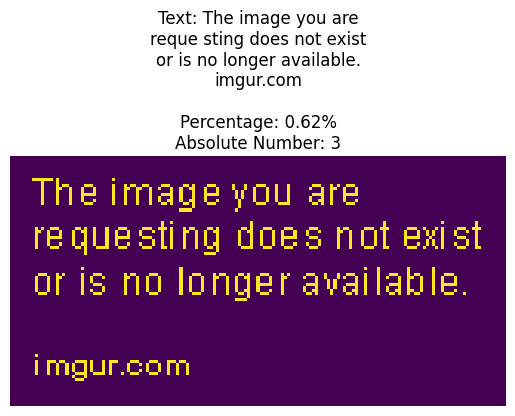

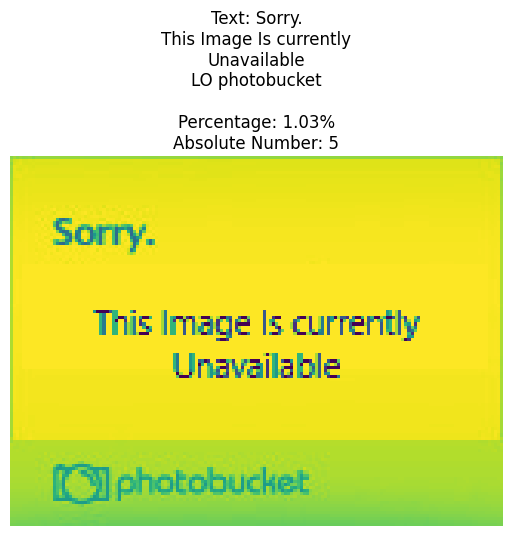

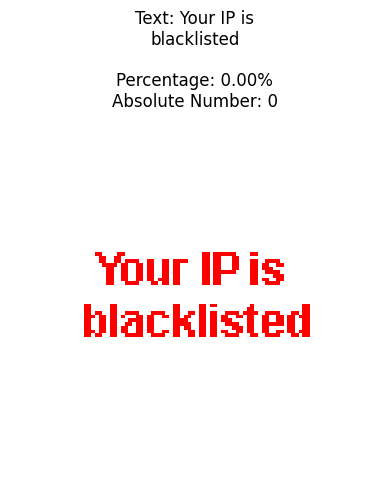

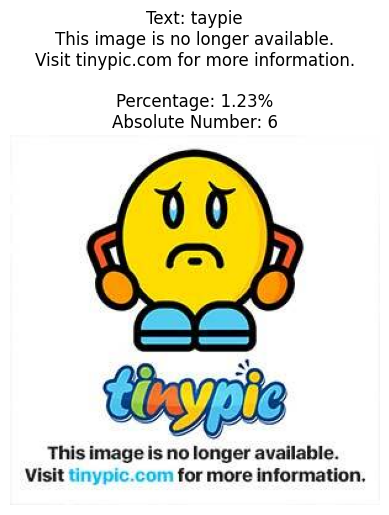

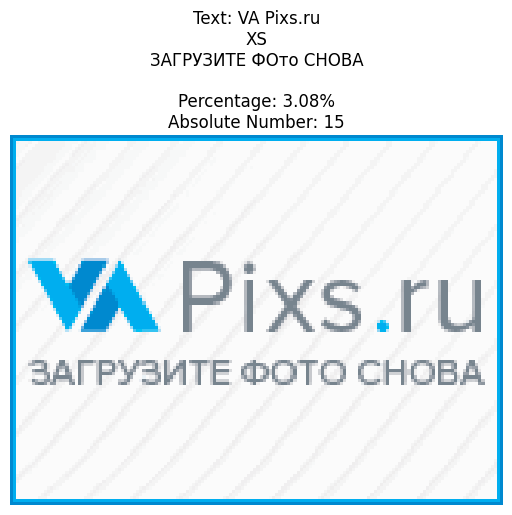

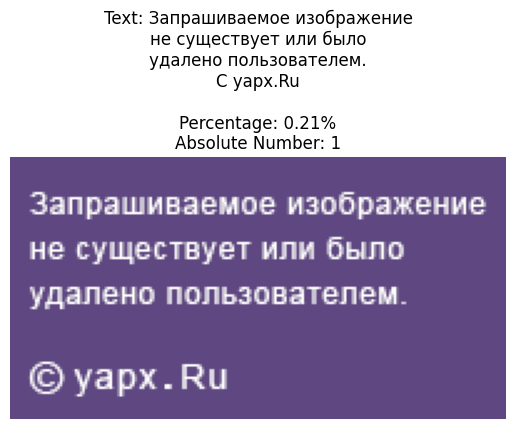

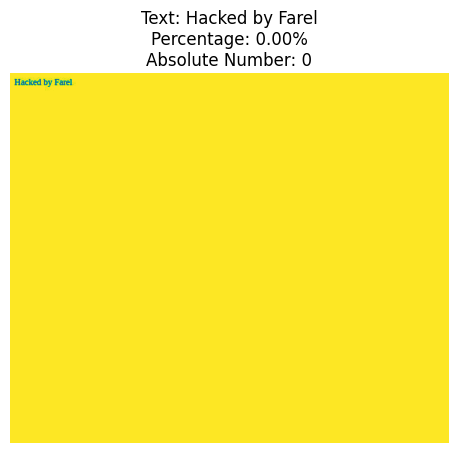

In [ ]:
total_images_df = len(val_df)
total_perc = 0
# For each text in NA_df, find its occurrence in df
for index, row in NA_df.iterrows():
    occurrences = len(val_df[val_df['text'] == row['text']])
    percentage = (occurrences / total_images_df) * 100
    total_perc += percentage
    # Display image with the stats
    img = mpimg.imread(row['file_path'])
    plt.imshow(img)
    plt.title(f"Text: {row['text']}\nPercentage: {percentage:.2f}%\nAbsolute Number: {occurrences}")
    plt.axis('off')  # to hide axes
    plt.show()



In [ ]:
print(f"Total Percentage: {total_perc}")

Total Percentage: 6.160164271047227


In [ ]:
# Visualize the results
texts = NA_df['text'].unique()

In [ ]:
# Total number of images in val_df
total_images_val = len(val_df)

# 1. Count matches by hash
hashes_na = {}
for index, row in NA_df.iterrows():
    image_path = row['file_path']
    with Image.open(image_path) as img:
        h = imagehash.dhash(img)
        hashes_na[h] = row['text']

hash_matches = {}
for h, text in hashes_na.items():
    matched_rows = val_df[val_df['file_path'].apply(lambda x: imagehash.dhash(Image.open(x)) == h)]
    hash_matches[text] = len(matched_rows)

/usr/local/lib/python3.10/dist-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


In [ ]:
text_matches = val_df[val_df['text'].isin(NA_df['text'])].groupby('text').size()

In [ ]:
def count_approximate_hash_matches(target_hash, hash_set, distance=1):
    """
    Count the number of hashes in hash_set that are within the given
    Hamming distance from the target hash.
    """
    count = 0
    for h in hash_set:
        if target_hash - h <= distance:
            count += 1
    return count


In [ ]:
# Convert hex hashes to ImageHash objects
hashes_val = val_df['file_path'].apply(lambda x: imagehash.dhash(Image.open(x)))

# Count the matches by approximate hash
hash_approx_matches = {}
for h, h_text in hashes_na.items():
    hash_approx_matches[h_text] = count_approximate_hash_matches(h, hashes_val)

# Calculate percentages
percent_by_text = [(text_matches.get(text, 0) / total_images_val) * 100 for text in texts]
percent_by_hash = [(hash_matches.get(text, 0) / total_images_val) * 100 for text in texts]
percent_by_approx_hash = [(hash_approx_matches.get(text, 0) / total_images_val) * 100 for text in texts]


/usr/local/lib/python3.10/dist-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


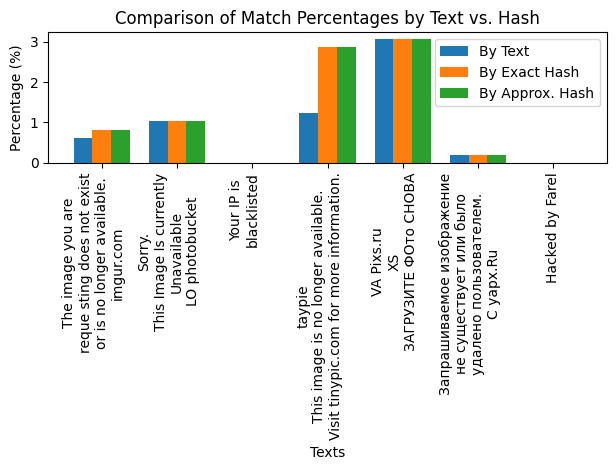

In [ ]:
x = range(len(texts))
bar_width = 0.25

plt.bar(x, percent_by_text, width=bar_width, label='By Text', align='center')
plt.bar([i + bar_width for i in x], percent_by_hash, width=bar_width, label='By Exact Hash', align='center')
plt.bar([i + 2 * bar_width for i in x], percent_by_approx_hash, width=bar_width, label='By Approx. Hash', align='center')

plt.xlabel('Texts')
plt.ylabel('Percentage (%)')
plt.title('Comparison of Match Percentages by Text vs. Hash')
plt.xticks([i + bar_width for i in x], texts, rotation='vertical')
plt.legend()
plt.tight_layout()
plt.show()

# Visualization for no-text images

In [ ]:
percentage_unknown = (val_df[val_df['text'] == 'unknown'].shape[0] / val_df.shape[0]) * 100
print(f"Percentage of 'unknown' in the data: {percentage_unknown:.2f}%")

Percentage of 'unknown' in the data: 21.36%


In [ ]:
# Extract the hashes of these images
no_text_hashes = {}
for index, row in no_text_images.iterrows():
    image_path = row['file_path']
    with Image.open(image_path) as img:
        h = imagehash.dhash(img)
        no_text_hashes[h] = "No Text"

# Count matches in val_df by exact hash
exact_hash_matches = {}
for h, text in no_text_hashes.items():
    matched_rows = val_df[val_df['file_path'].apply(lambda x: imagehash.dhash(Image.open(x)) == h)]
    exact_hash_matches[text] = len(matched_rows)

# Count matches in val_df by approximate hash
approx_hash_matches = {}
for h, text in no_text_hashes.items():
    approx_hash_matches[text] = count_approximate_hash_matches(h, hashes_val)

# Calculate percentages
total_images_val = len(val_df)
percent_by_hash = [(exact_hash_matches.get(text, 0) / total_images_val) * 100 for text in ["No Text", "No Text"]]
percent_by_approx_hash = [(approx_hash_matches.get(text, 0) / total_images_val) * 100 for text in ["No Text", "No Text"]]


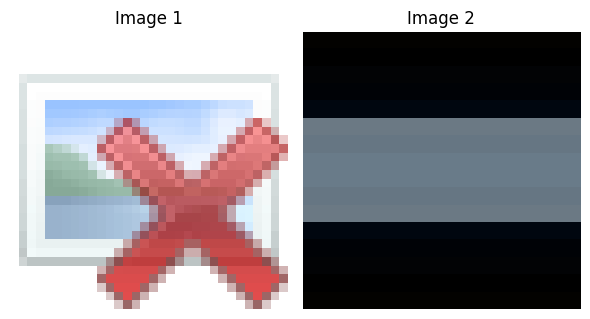

In [ ]:
# Visualize the results
labels = ["Image 1", "Image 2"]
# Display Images in one figure
fig1 = plt.figure(figsize=(6, 4))

# Display Image 1
ax1 = fig1.add_subplot(1, 2, 1)
img1_path = no_text_images.iloc[0]['file_path']
img1 = mpimg.imread(img1_path)
ax1.imshow(img1)
ax1.axis('off')
ax1.set_title('Image 1')

# Display Image 2
ax2 = fig1.add_subplot(1, 2, 2)
img2_path = no_text_images.iloc[1]['file_path']
img2 = mpimg.imread(img2_path)
ax2.imshow(img2)
ax2.axis('off')
ax2.set_title('Image 2')

plt.tight_layout()
plt.show()


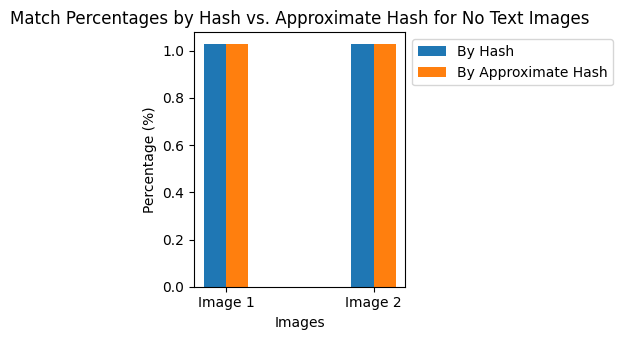

In [ ]:
# Display Bar Chart in a separate figure
bar_width = 0.15
x_positions = np.arange(len(labels))
plt.figure(figsize=(5, 3.5))
plt.bar(x_positions, percent_by_hash, width=bar_width, label='By Hash', align='center')
plt.bar([i + bar_width for i in x_positions], percent_by_approx_hash, width=bar_width, label='By Approximate Hash', align='center')

plt.xlabel('Images')
plt.ylabel('Percentage (%)')
plt.title('Match Percentages by Hash vs. Approximate Hash for No Text Images')
plt.xticks([i + 0.5 * bar_width for i in x_positions], labels)
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))

plt.tight_layout()
plt.show()